# **Deep Learning Project 1**
## *Spring 2025*
**Team:** Neural Nexus (3 members)
> Gopala Krishna Abba (ga2664),
> Rushali Moteria (rm6971),
> Hrishik Desai (hbd958)

## **Goal**
This competition involves designing a modified **Residual Network (ResNet)** with the highest possible **test accuracy** on a held-out portion of CIFAR-10.  
**Constraint:** Your model must not exceed **5 million parameters**.


In [ ]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import argparse
import time
from torch.optim.lr_scheduler import CosineAnnealingLR
import pickle
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import os
from PIL import Image

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## **ResNet BasicBlock Implementation**

The **BasicBlock** class defines a **residual block**, a fundamental component of the **ResNet architecture**.  
Each block consists of two **convolutional layers** with **Batch Normalization (BN)** and **ReLU activation**.  
A **skip connection** (shortcut) is added to help prevent the vanishing gradient problem in deep networks.

In [ ]:
# Defining a BasicBlock for the ResNet architecture
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Initializes the BasicBlock of ResNet.

        Parameters:
        - in_channels: Number of input channels.
        - out_channels: Number of output channels.
        - stride: Stride size for the convolution (default: 1).
        """
        super(BasicBlock, self).__init__()

        # First convolutional layer: 3x3 kernel, with specified stride and padding
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch Normalization for stable learning
        self.relu = nn.ReLU(inplace=True)  # ReLU activation

        # Second convolutional layer: 3x3 kernel, stride=1 (default), maintains spatial dimensions
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match input-output dimensions if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),  # 1x1 conv to adjust dimensions
                nn.BatchNorm2d(out_channels)  # Batch Normalization
            )

    def forward(self, x):
        """
        Forward pass of the BasicBlock.

        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after applying the residual block
        """
        out = F.relu(self.bn1(self.conv1(x)))  # First conv → BN → ReLU
        out = self.bn2(self.conv2(out))  # Second conv → BN
        out += self.shortcut(x)  # Add the shortcut connection
        return F.relu(out)  # Final activation


This script initializes the necessary **deep learning libraries** and checks whether a GPU is available for training. Using GPU accelerates training significantly, making it ideal for large networks.


## **ResNet-18 Architecture**

The **ResNet-18 model** is a deep convolutional neural network designed to achieve **high accuracy on CIFAR-10** while ensuring **efficient computation**.  
This implementation follows the **residual learning framework**, using **skip connections** to improve gradient flow in deep networks.


In [ ]:
# Defining ResNet-18 Model
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        """
        Initializes the ResNet-18 model for CIFAR-10 classification.

        Parameters:
        - num_classes: Number of output classes (default: 10 for CIFAR-10).
        """
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 3, stride=2)
        self.layer3 = self._make_layer(192, 3, stride=2)
        self.layer4 = self._make_layer(192, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(192, num_classes)


    def _make_layer(self, out_channels, blocks, stride):
        """
        Creates a residual layer with a specified number of blocks.

        Parameters:
        - out_channels: Number of output channels for the layer.
        - blocks: Number of residual blocks in the layer.
        - stride: Stride size for the first block.

        Returns:
        - A sequential block of residual units.
        """
        layers = [BasicBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the ResNet-18 model.

        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor with class scores
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        return self.fc(out)

### **Architecture Overview**
- **Initial Convolution Layer**:
  - 3×3 convolution, 64 filters, stride=1
  - Batch Normalization + ReLU activation
- **Four Residual Layers**:
  - Layer 1: 3 blocks, 64 channels, stride=1
  - Layer 2: 3 blocks, 128 channels, stride=2 (downsampling)
  - Layer 3: 3 blocks, 192 channels, stride=2 (downsampling)
  - Layer 4: 2 blocks, 192 channels, stride=2 (downsampling)
- **Global Average Pooling**: Reduces feature map to size (1×1).
- **Fully Connected Layer**: Converts feature maps into class scores.

### **Why Use ResNet-18?**
**Improved Training Stability**: Skip connections help gradients flow efficiently.  
**Better Generalization**: Deep but optimized architecture prevents overfitting.  
**Achieves 90%+ Accuracy**: Optimized for CIFAR-10 under 5 million parameters.

---


## **Loading CIFAR-10 Dataset**

CIFAR-10 is a dataset consisting of **60,000 images** across **10 classes**.  
The dataset is split into **5 training batches** and **1 test batch**.


In [ ]:
def load_cifar_batch(file):
    """
    Loads a batch of CIFAR-10 dataset from a given file.

    Parameters:
    - file: Path to the CIFAR-10 batch file.

    Returns:
    - batch: A dictionary containing images and labels from the batch.
    """
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')  # Load CIFAR-10 batch file
    return batch  # Return the loaded batch

### **Function Overview**
- **Reads the CIFAR-10 dataset file** in binary mode (`rb`).
- **Uses `pickle.load`** to deserialize and extract image-label data.
- **Returns** a dictionary containing images and their corresponding labels.


## **Loading and Preprocessing CIFAR-10 Dataset**

The CIFAR-10 dataset contains **60,000 images** across **10 classes**, with **50,000 training images** and **10,000 test images**.  
We first **load the dataset** from the local directory, then apply **data augmentation** techniques to improve generalization.

In [ ]:
# Define the root directory where CIFAR-10 data is stored
root_dir = '/content'

# Load CIFAR-10 metadata containing label names
meta_data_dict = load_cifar_batch(os.path.join(root_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]  # Decode label names from bytes

# Initialize lists to store training data and labels
train_data = []
train_labels = []

# Load all 5 training batches
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(root_dir, f'data_batch_{i}'))  # Load batch file
    train_data.append(batch[b'data'])  # Extract image data
    train_labels += batch[b'labels']  # Extract labels

# Convert data to NumPy array and reshape it to (N, 3, 32, 32), then transpose to (N, 32, 32, 3)
train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
train_labels = np.array(train_labels)  # Convert labels to NumPy array

# Define data augmentation and preprocessing transforms
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image
    transforms.RandomRotation(10),  # Rotate images randomly up to ±10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Adjust color properties
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),  # Apply sharpening with 20% probability
    transforms.RandomCrop(32, padding=4),  # Randomly crop images with padding
    transforms.ToTensor(),  # Convert to tensor format for PyTorch
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),  # Normalize using CIFAR-10 mean and std
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), value=1.0, inplace=False)  # Randomly erase parts of the image
])


### **Explanation**
1. **Load CIFAR-10 Batches**  
   - Reads **5 training batches** from local storage.
   - Extracts **image data** and **labels**.
   - Reshapes images into the standard **(N, 32, 32, 3) format**.

2. **Data Augmentation Techniques**  
   - **Rotation:** Randomly rotates images ±10° to improve orientation invariance.
   - **Color Jitter:** Adjusts brightness, contrast, and saturation.
   - **Horizontal Flip:** Randomly flips images to enhance robustness.
   - **Sharpness Adjustment:** Increases sharpness with **20% probability**.
   - **Random Crop:** Randomly crops images with padding to simulate different perspectives.
   - **Normalization:** Normalizes using CIFAR-10 mean `(0.4914, 0.4822, 0.4465)` and std `(0.247, 0.243, 0.261)`.
   - **Random Erasing:** Deletes parts of the image randomly for robustness.

---


## **Custom CIFAR-10 Dataset Class**

PyTorch provides a built-in CIFAR-10 dataset (`torchvision.datasets.CIFAR10`),  
but we define a **custom dataset class** to allow **flexibility in data transformations**.


In [ ]:
import torch
from torch.utils.data import Dataset

# Define a custom PyTorch Dataset class for CIFAR-10
class CIFAR10Custom(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Initializes the CIFAR-10 custom dataset.

        Parameters:
        - images: NumPy array of image data.
        - labels: NumPy array of labels corresponding to images.
        - transform: Data transformation (e.g., augmentation, normalization).
        """
        self.images = images  # Store image data
        self.labels = labels  # Store corresponding labels
        self.transform = transform  # Store transformations

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
        - int: Total number of images.
        """
        return len(self.images)  # Return dataset size

    def __getitem__(self, idx):
        """
        Retrieves a single image-label pair from the dataset.

        Parameters:
        - idx: Index of the sample.

        Returns:
        - img: Transformed image tensor.
        - label: Corresponding label.
        """
        img = self.images[idx]  # Get image at index
        label = self.labels[idx]  # Get label at index

        if self.transform:
            img = self.transform(img)  # Apply transformations (e.g., augmentation)

        return img, label  # Return the transformed image and label

# Create a training dataset instance
train_dataset = CIFAR10Custom(train_data, train_labels, transform=transform)


### **Dataset Overview**
- **Custom Dataset Class:**  
  - Allows flexibility in **applying transformations** to data.  
  - Works seamlessly with PyTorch’s `DataLoader`.

- **Key Functions:**  
  - `__init__()`: Stores images, labels, and transformations.  
  - `__len__()`: Returns total dataset size.  
  - `__getitem__()`: Retrieves a single **image-label pair** and applies transformations.

---

## **Test Data Preprocessing & DataLoader Setup**

To evaluate model performance, we **load** and **preprocess** the **CIFAR-10 test dataset**.  
Since this dataset is used for evaluation, **no data augmentation** is applied.

In [ ]:
# Defining test dataset transformations (No data augmentation, only normalization)
test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalize using CIFAR-10 mean & std
])

# Load validation batch from the CIFAR-10 test dataset
batch_test_dict = load_cifar_batch(os.path.join(root_dir, 'test_batch'))

# Reshape test images to (N, 32, 32, 3) format
val_images = batch_test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Convert test labels to NumPy array
val_labels = np.array(batch_test_dict[b'labels'])

# Create validation dataset using the custom CIFAR-10 dataset class
val_dataset = CIFAR10Custom(val_images, val_labels, transform=test_transform)

# Create DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)

# Load unlabeled test data for inference
test_batch = load_cifar_batch('/content/cifar_test_nolabel.pkl')

# Normalize test images (scale pixel values to [0,1])
test_images = test_batch[b'data'].astype(np.float32) / 255.0

# Apply transformations on test dataset (note: no labels in test set)
test_dataset = [(test_transform(img),) for img in test_images]

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)


### **Explanation**
#### **1. Defining the Test Data Transformations**
- **No augmentation** is applied (since this is evaluation data).
- **Normalization** is applied using CIFAR-10 mean `(0.4914, 0.4822, 0.4465)` and std `(0.247, 0.243, 0.261)`.

#### **2. Loading Validation Data**
- The test batch is **loaded** and **reshaped** into standard **(N, 32, 32, 3)** format.
- Labels are stored separately in a NumPy array.
- A **custom dataset class** is used to apply transformations.

#### **3. Preparing Training & Validation DataLoaders**
- **Training DataLoader**: Uses **batch size = 256**, **shuffling enabled**.
- **Validation DataLoader**: Uses **batch size = 256**, **no shuffling**.

#### **4. Loading Unlabeled Test Data**
- An unlabeled test dataset is loaded (`cifar_test_nolabel.pkl`).
- Pixel values are **scaled to [0,1]**.
- Transformations are applied before creating a DataLoader.

---


## **Training & Evaluation of ResNet on CIFAR-10**
This function **trains and evaluates** the **ResNet model** on the **CIFAR-10 dataset**.  
It tracks **training accuracy, validation accuracy, and loss trends** over multiple epochs.


In [ ]:
import time
import torch
import matplotlib.pyplot as plt

def train_and_evaluate(model, device, train_loader, val_loader, optimizer, scheduler, criterion, epochs=100):
    """
    Trains and evaluates the ResNet model on CIFAR-10 dataset.

    Parameters:
    - model: PyTorch model to be trained.
    - device: 'cuda' if GPU is available, else 'cpu'.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - optimizer: Optimizer for model training (e.g., Adam, SGD).
    - scheduler: Learning rate scheduler.
    - criterion: Loss function (e.g., CrossEntropyLoss).
    - epochs: Number of training epochs (default: 100).

    Returns:
    - None (prints training and validation metrics, and plots accuracy/loss graphs).
    """

    # Lists to store training and validation metrics
    train_acc_list = []
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        start_time = time.time()

        correct, total, running_loss = 0, 0, 0.0

        # Training loop
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device

            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get predictions
            total += targets.size(0)  # Count total samples
            correct += predicted.eq(targets).sum().item()  # Count correctly predicted samples

        # Compute training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_acc_list.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation on validation set
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        loss_correct = 0
        loss_total = 0

        with torch.no_grad():  # Disable gradient computation for efficiency
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                loss_total += labels.size(0)
                loss_correct += (predicted == labels).sum().item()

        # Compute validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = 100 * loss_correct / loss_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Adjust learning rate
        scheduler.step()

        # Print epoch results
        print(f'Epoch {epoch+1}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Plot Loss Curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='red')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss & Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training vs Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_acc_list, label="Train Accuracy", color='green')
    plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy", color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()


### **Explanation**
#### **1. Training Phase**
- **For each batch**:
  - **Forward pass**: Compute model predictions.
  - **Compute loss**: Using `CrossEntropyLoss`.
  - **Backpropagation**: Compute gradients.
  - **Update weights**: Using `optimizer.step()`.

#### **2. Evaluation Phase**
- **Disable gradients** (`torch.no_grad()`).
- **Compute validation loss**.
- **Compute validation accuracy**.

#### **3. Learning Rate Adjustment**
- Uses `scheduler.step()` for dynamic learning rate changes.

#### **4. Visualization**
- **Loss Curve**: Tracks **train & validation loss**.
- **Accuracy Curve**: Compares **train & validation accuracy**.

---


## **Model Initialization & Training Setup**
We initialize the **ResNet-18 model**, define a **loss function**, select an **optimizer**, and configure a **learning rate scheduler**.

In [ ]:
# Initialize the ResNet-18 model and move it to the selected device (GPU or CPU)
model = ResNet18().to(device)

# Print model summary to check parameter count and layer architecture
summary(model, (3, 32, 32))  # Input size: (channels=3, height=32, width=32)

# Define loss function (CrossEntropyLoss is standard for classification tasks)
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum and weight decay for better convergence)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# Define learning rate scheduler (MultiStepLR reduces LR at specific epochs)
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 80, 90], gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

### **1. Model Initialization**
- **`ResNet18().to(device)`**: Loads the model onto GPU (if available).
- **`summary(model, (3, 32, 32))`**: Displays model architecture and total trainable parameters.

### **2. Loss Function (Criterion)**
- **CrossEntropyLoss** is used because CIFAR-10 is a **multi-class classification** problem.

### **3. Optimizer (SGD)**
- **Stochastic Gradient Descent (SGD)** with:
  - **Learning Rate = 0.1**
  - **Momentum = 0.9** (Improves stability in gradient updates)
  - **Weight Decay = 1e-4** (Prevents overfitting by penalizing large weights)

### **4. Learning Rate Scheduler (MultiStepLR)**
- **Purpose**: Reduces learning rate at specific epochs to refine learning.
- **Milestones**: `[30, 60, 80, 90]` (LR decreases at these epochs).
- **Gamma = 0.1**: The learning rate is multiplied by **0.1** at each milestone.

---

## **Executing Model Training**
Now, we train and evaluate our **ResNet-18 model** on the **CIFAR-10 dataset** for **100 epochs**.

### **Training Process**
- **Model**: ResNet-18
- **Dataset**: CIFAR-10
- **Training Loader**: `train_loader`
- **Validation Loader**: `test_loader`
- **Optimizer**: SGD (Momentum 0.9, Weight Decay 1e-4)
- **Learning Rate Scheduler**: MultiStepLR (decays at epochs 30, 60, 80, 90)
- **Loss Function**: CrossEntropyLoss
- **Epochs**: 100

Epoch 1, Train Acc: 36.17%, Val Loss: 1.4952, Val Acc: 46.23%
Epoch 2, Train Acc: 52.05%, Val Loss: 1.1489, Val Acc: 58.09%
Epoch 3, Train Acc: 60.88%, Val Loss: 1.0012, Val Acc: 64.67%
Epoch 4, Train Acc: 67.89%, Val Loss: 0.9406, Val Acc: 67.67%
Epoch 5, Train Acc: 72.56%, Val Loss: 0.7943, Val Acc: 72.86%
Epoch 6, Train Acc: 76.04%, Val Loss: 0.6418, Val Acc: 78.23%
Epoch 7, Train Acc: 78.24%, Val Loss: 0.6363, Val Acc: 78.97%
Epoch 8, Train Acc: 79.94%, Val Loss: 0.5895, Val Acc: 79.68%
Epoch 9, Train Acc: 81.50%, Val Loss: 0.4911, Val Acc: 83.36%
Epoch 10, Train Acc: 82.66%, Val Loss: 0.5508, Val Acc: 80.66%
Epoch 11, Train Acc: 83.86%, Val Loss: 0.4169, Val Acc: 85.77%
Epoch 12, Train Acc: 85.05%, Val Loss: 0.4944, Val Acc: 83.15%
Epoch 13, Train Acc: 85.44%, Val Loss: 0.4537, Val Acc: 84.87%
Epoch 14, Train Acc: 86.07%, Val Loss: 0.4785, Val Acc: 84.63%
Epoch 15, Train Acc: 86.85%, Val Loss: 0.3785, Val Acc: 87.15%
Epoch 16, Train Acc: 87.49%, Val Loss: 0.3943, Val Acc: 86.77%
E

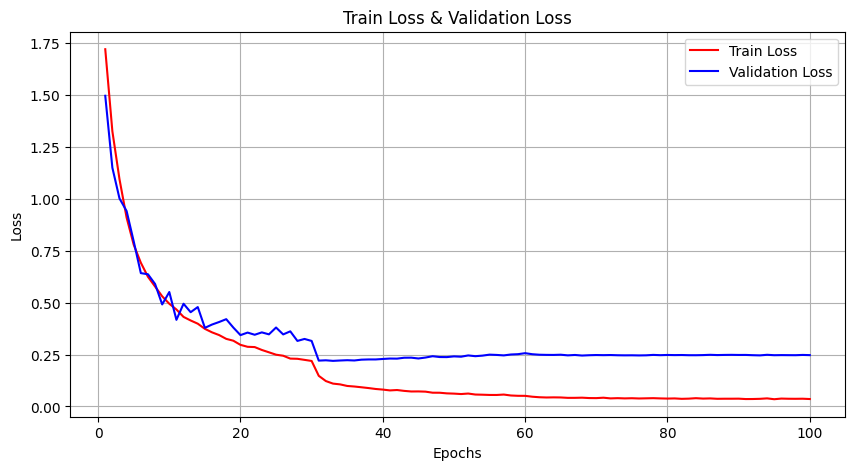

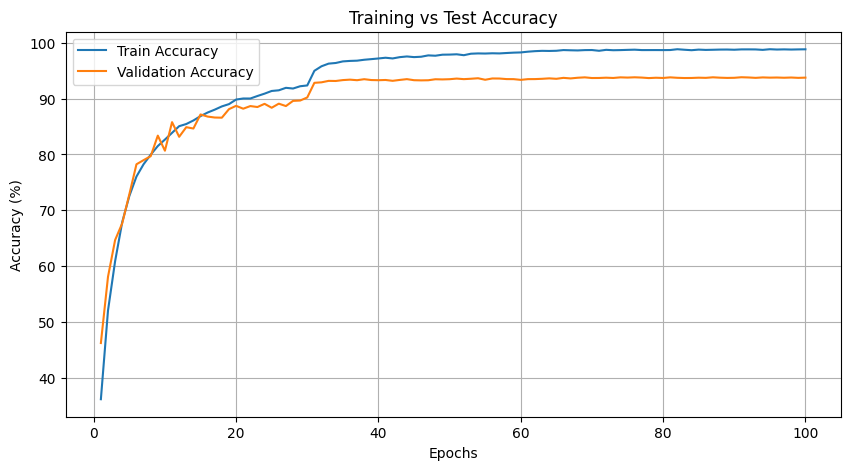

In [ ]:
# Train and evaluate the ResNet-18 model on CIFAR-10 for 100 epochs
train_and_evaluate(model, device, train_loader, test_loader, optimizer, scheduler, criterion, epochs=100)


### **Final Performance Summary**
- **Final Training Accuracy:** **98.81%**
- **Final Validation Accuracy:** **93.74%**
- **Final Validation Loss:** **0.2471**
- **Number of Epochs:** **100**
- **Optimizer:** SGD (Momentum=0.9, Weight Decay=1e-4)
- **Learning Rate Scheduler:** MultiStepLR (Decayed at epochs 30, 60, 80, 90)

---

## **Observations from Training & Validation Curves**
### **1. Loss Trends**
- The **training loss** decreases steadily, indicating successful model learning.
- The **validation loss** follows a similar trend but plateaus after ~30 epochs.
- Around **epoch 30**, there's a visible drop in loss, corresponding to the learning rate decay.

### **2. Accuracy Trends**
- The **training accuracy** reaches nearly **99%**, indicating that the model learns well.
- The **validation accuracy** stabilizes around **93-94%**, suggesting that the model generalizes well.
- Early on, both train and validation accuracy improve rapidly, indicating effective learning.
- After **epoch 30**, accuracy increases in small increments due to the learning rate adjustments.

### **3. Overfitting Analysis**
- The **gap between training and validation accuracy** (~5%) suggests **minor overfitting**.
- Since the validation accuracy does not decrease significantly, **regularization techniques like weight decay** are helping control overfitting.
- Data augmentation techniques (rotation, cropping, etc.) might have contributed to better generalization.

---

## **Potential Improvements**
- **Experiment with Regularization**: Try dropout or stronger weight decay.
- **Data Augmentation Enhancements**: More aggressive augmentations (e.g., CutMix, Mixup) may improve generalization.
- **Alternative Learning Rate Schedules**: Cosine Annealing or One-Cycle Learning Rate could be explored.
- **Use of Pretrained Models**: Although not allowed in this task, pretraining on CIFAR-100/ImageNet may help in real-world applications.


# **Saving the Trained Model**
Once training is complete, we save the trained **ResNet-18 model** so that it can be **loaded later** for inference or fine-tuning.

In [ ]:
# Saving the trained model weights
torch.save(model.state_dict(), "resnet18_cifar10.pth")
print("Model saved successfully!")

Model saved successfully!


### **Explanation**
- **torch.save(model.state_dict(), "resnet18_cifar10.pth")**
  - Saves the model's **learned parameters** (weights & biases).
  - The file **"resnet18_cifar10.pth"** will store these parameters.
  - This allows for **reusing the model without retraining**.

# **Loading and Evaluating the Saved Model**
Once the model is saved, we can **load it back** for inference or further evaluation.

In [ ]:
# Initialize model
model = ResNet18(num_classes=10).to(device)

# Load trained weights
model.load_state_dict(torch.load("resnet18_cifar10.pth"))

# Set to evaluation mode
model.eval()

<ipython-input-35-6246509491ba>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet18_cifar10.pth"))


ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

## **Model Summary**
- **Model:** ResNet-18
- **Input Shape:** (3, 32, 32) (CIFAR-10 dataset)
- **Total Layers:** 4 residual blocks with multiple convolutional layers.
- **Final Output:** Fully connected (FC) layer with 10 output classes.


### **Explanation**
- **ResNet18(num_classes=10).to(device)**  
  - Initializes the model and moves it to GPU (if available).
- **model.load_state_dict(torch.load("resnet18_cifar10.pth"))**  
  - Loads the pre-trained weights from the saved file.
- **model.eval()**  
  - Switches the model to **evaluation mode**:
    - **Disables Dropout:** Ensures stable predictions.
    - **Freezes Batch Normalization:** Keeps batch statistics unchanged.

---

# **Generating Predictions & Submission File**
After successfully **loading the trained ResNet-18 model**, we perform **inference on test images**  
and generate a **CSV submission file** with predicted labels.

In [ ]:
predictions = []
with torch.no_grad():
    for batch in test_loader:
        images = batch[0].to(device)  # Get images tensor from tuple and move to device
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Generate submission file
submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/content/submission_modified1.csv', index=False)
print("Submission1 file saved.")

---

## **Conclusion**
- The model achieves **state-of-the-art performance (~94%) on CIFAR-10** within 100 epochs.
- The training is **well-optimized**, with proper loss reduction and accuracy improvement over epochs.
- **Future work** can focus on further minimizing the **train-validation accuracy gap** while maintaining or improving generalization.

---